In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
# from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
from scipy.fftpack import fft
from sklearn.preprocessing import PowerTransformer, TargetEncoder
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import STL

/Users/boyarskikh/Documents/Магистратура/apsm/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 23
N_TRIALS = 25
FILE_PATH = 'currency_raw.parquet'
FILE_TYPE = 'currency'
TICKER = 'USDRUB'
TICKER_TYPE = 'Open'

In [3]:
def preprocess_time_series(
    df: pd.DataFrame,
    target: str,
    transformers: dict = None,
    do_scale: bool = True,
    do_diff: bool = True,
    do_yeo_johnson: bool = True,
    do_window_normalizing: bool = True,
    window_size: int = 10,
    do_encode: bool = True,
    is_train: bool = False
):
    """
    Предобрабатывает временной ряд для столбца 'target' в DataFrame, изменяя только этот столбец,
    с возможностью восстановления исходных значений. Учитывает data leakage.

    Параметры:
    ----------
    df : pd.DataFrame
        Исходный DataFrame.
    target : str
        Название столбца, для которого выполняются преобразования.
    transformers : dict, optional
        Словарь с объектами трансформеров (используется при is_train=False).
    do_scale : bool, по умолчанию True
        Выполнять ли масштабирование.
    do_diff : bool, по умолчанию True
        Выполнять ли дифференцирование.
    do_yeo_johnson : bool, по умолчанию True
        Выполнять ли преобразование Yeo-Johnson.
    do_window_normalizing : bool, по умолчанию True
        Выполнять ли оконную нормализацию.
    window_size : int, по умолчанию 10
        Размер окна для оконной нормализации.
    do_encode : bool
        Выполнять ли кодировку категориальных признаков.
    is_train : bool, по умолчанию True
        Флаг, указывающий, являются ли данные тренировочными.

    Возвращает:
    -----------
    df_transformed : pd.DataFrame
        Преобразованный DataFrame с только изменённым столбцом 'target'.
    transformers : dict
        Словарь с объектами трансформеров для восстановления значений.
    """
    df_transformed = df.copy()
    ts = df_transformed[target].copy()

    if is_train:
        transformers = {}
    elif transformers is None:
        raise ValueError('Для тестовых данных необходимо передать transformers.')

    # Масштабирование.
    if do_scale:
        values = ts.values.reshape(-1, 1)

        if is_train:
            scaler = StandardScaler()
            scaled_values = scaler.fit_transform(values)
            transformers['scaler'] = scaler
        else:
            scaler = transformers['scaler']
            scaled_values = scaler.transform(values)

        ts = pd.Series(
            data=scaled_values.flatten(),
            index=ts.index,
            name=ts.name
        )

    # Дифференцирование.
    if do_diff:
        if is_train:
            transformers['last_value'] = ts.iloc[0]
        ts = ts.diff()
        ts.dropna(inplace=True)

    # Преобразование Yeo-Johnson.
    if do_yeo_johnson:
        if is_train:
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            non_nan_values = ts.values[~np.isnan(ts.values)].reshape(-1, 1)
            if len(non_nan_values) > 0:
                pt.fit(non_nan_values)
            transformers['yeo_johnson'] = pt
        
        pt = transformers['yeo_johnson']
        transformed_values = np.full_like(ts.values, np.nan, dtype=float)
        non_nan_mask = ~np.isnan(ts.values)
        non_nan_values = ts.values[non_nan_mask].reshape(-1, 1)
        
        if len(non_nan_values) > 0:
            transformed_values[non_nan_mask] = pt.transform(non_nan_values).flatten()
        
        ts = pd.Series(transformed_values, index=ts.index, name=ts.name)

    # Оконная нормализация.
    if do_window_normalizing:
        ts_rolled = ts.rolling(window=window_size)

        rolled_mean = ts_rolled.mean()
        rolled_std = ts_rolled.std()

        eps = 1e-9
        ts = (ts - rolled_mean) / (rolled_std + eps)
        ts = ts[window_size - 1:]

    df_transformed[target] = ts
    df_transformed.dropna(inplace=True)

    if do_encode:
        if is_train:
            encoder = TargetEncoder(cv=3, random_state=RANDOM_STATE)
            df_transformed['ticker'] = encoder.fit_transform(X=df_transformed[['ticker']], y=ts)
            
            transformers['encoder'] = encoder
        else:
            encoder = transformers['encoder']
            df_transformed['ticker'] = encoder.transform(X=df_transformed[['ticker']])

    return df_transformed.set_index('Date'), transformers


def inverse_preprocess_time_series(
    ts_transformed: np.array,
    transformers: dict,
    do_scale: bool = True,
    do_diff: bool = True,
    do_yeo_johnson: bool = True,
    do_window_normalizing: bool = True
) -> np.array:
    """
    Восстанавливает исходный временной ряд из преобразованного np.array,
    используя сохранённые параметры трансформаций, выполненных в функции preprocess_time_series.

    Параметры:
    -----------
    ts_transformed : np.array
        Преобразованный временной ряд.
    transformers : dict
        Словарь с сохранёнными объектами и параметрами трансформаций.
    do_scale : bool, по умолчанию True
        Выполнять ли масштабирование.
    do_diff : bool, по умолчанию True
        Выполнять ли дифференцирование.
    do_yeo_johnson : bool, по умолчанию True
        Выполнять ли преобразование Yeo-Johnson.
    do_window_normalizing : bool, по умолчанию True
        Выполнять ли оконную нормализацию.

    Возвращает:
    -----------
    np.array
        Восстановленный временной ряд в исходных единицах измерения.
    """
    ts = ts_transformed.copy()

    # Обратная оконная нормализация
    if do_window_normalizing:
        eps = 1e-9
        rolled_mean = transformers.get('rolled_mean')
        rolled_std = transformers.get('rolled_std')

        if rolled_mean is None or rolled_std is None:
            raise ValueError(
                "Нет сохранённых параметров оконной нормализации: 'rolled_mean' или 'rolled_std'."
            )

    # Обратное преобразование Yeo-Johnson
    if do_yeo_johnson and 'yeo_johnson' in transformers:
        pt = transformers['yeo_johnson']
        ts = pt.inverse_transform(ts.reshape(-1, 1)).flatten()

    # Обратное дифференцирование
    if do_diff and 'last_value' in transformers:
        ts = np.cumsum(ts) + transformers['last_value']

    # Обратное масштабирование
    if do_scale and 'scaler' in transformers:
        scaler = transformers['scaler']
        ts = scaler.inverse_transform(ts.reshape(-1, 1)).flatten()

    return ts


def extract_time_series_features(
    df: pd.Series,
    lags=[1, 2, 3, 4, 5],
    rolling_windows=[7, 30],
    fourier_periods=[7, 30]
):
    """
    Функция для автоматического извлечения признаков из временного ряда.

    Аргументы:
      df : pandas.Series или pandas.DataFrame
          Временной ряд с индексом типа datetime.
      lags : list, по умолчанию [1, 2, 3, 4, 5]
          Лаговые признаки.
      rolling_windows : list, по умолчанию [3, 5, 7, 9]
          Скользящие статистики.
      fourier_periods : list, по умолчанию [7, 30]
          Периоды для Фурье-признаков.

    Возвращает:
      DataFrame с извлеченными признаками.
    """
    if isinstance(df, pd.Series):
        df = df.to_frame(name='value')
    else:
        df = df.copy()

        if 'value' not in df.columns:
            df = df.iloc[:, [0]]
            df.columns = ['value']

    df = df.sort_index()

    # Календарные признаки.
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Лаговые признаки.
    for lag in lags:
        df[f'lag_{lag}'] = df['value'].shift(lag)

    # Разностные признаки.
    for lag in lags:
        df[f'diff_{lag}'] = df['value'] - df['value'].shift(lag)

    # Скользящие статистики.
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df['value'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['value'].rolling(window=window).std()
        df[f'rolling_min_{window}'] = df['value'].rolling(window=window).min()
        df[f'rolling_max_{window}'] = df['value'].rolling(window=window).max()

    # Признаки Фурье.
    t = np.arange(len(df))

    for period in fourier_periods:
        df[f'sin_{period}'] = np.sin(2 * np.pi * t / period)
        df[f'cos_{period}'] = np.cos(2 * np.pi * t / period)

    # Анализ Фурье.
    ts_filled = df['value'].ffill().values
    fft_values = fft(ts_filled)
    fft_power = np.abs(fft_values)**2
    dominant_idx = np.argmax(fft_power[1:]) + 1
    dominant_frequency = dominant_idx / len(df)
    df['dominant_frequency'] = dominant_frequency

    # Групповые статистики.
    df['weekday_mean'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('mean')
    df['weekday_std'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('std')
    df['weekday_min'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('min')
    df['weekday_max'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('max')

    for window in rolling_windows:
        df[f'rolling_median_{window}'] = df['value'].rolling(window=window).median()
        df[f'rolling_q25_{window}'] = df['value'].rolling(window=window).quantile(0.25)
        df[f'rolling_q75_{window}'] = df['value'].rolling(window=window).quantile(0.75)

    # Признаки на основе статистических моделей.
    stl = STL(df['value'].ffill(), period=12, seasonal=7)
    res = stl.fit()

    df['stl_trend'] = res.trend
    df['stl_seasonal'] = res.seasonal
    df['stl_residual'] = res.resid

    # Целевая переменная.
    df['target'] = df['value']
    df.drop(columns=['value'], inplace=True)
    df.dropna(inplace=True)

    return df


def split_time_series(
        df: pd.DataFrame,
        ticker: str,
        train_size=0.7,
        val_size=0.2,
        test_size=0.1
):
    """
    Разбивает отсортированный временной ряд на обучающую, валидационную и тестовую выборки.

    Parameters:
      df : pd.DataFrame
        Временной ряд.
      ticker : str
        Тикер для фильтрации тестовых данных.
      train_size : float
        Пропорция обучающей выборки.
      val_size : float
        Пропорция валидационной выборки.
      test_size : float
        Пропорция тестовой выборки.

    Returns:
      df_train, df_val, df_test : pd.DataFrame
        Разделённые данные.
    """
    df_train_list, df_val_list, df_test_list = [], [], []

    for ticker, group in df.groupby('ticker'):
        group = group.sort_values(by='Date')

        n = len(group)
        train_end = int(n * train_size)
        val_end = train_end + int(n * val_size)

        df_train_list.append(group.iloc[:train_end])
        df_val_list.append(group.iloc[train_end:val_end])
        df_test_list.append(group.iloc[val_end:])

    df_train = pd.concat(df_train_list).reset_index(drop=True)
    df_val = pd.concat(df_val_list).reset_index(drop=True)
    df_test = pd.concat(df_test_list).reset_index(drop=True)

    df_test = df_test[df_test['ticker'] == 'USDRUB']

    return df_train, df_val, df_test    


def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    model = XGBRegressor(
        **params,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        verbosity=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_cb(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    }

    model = CatBoostRegressor(
        **params,
        random_state=RANDOM_STATE,
        thread_count=-1,
        verbose=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    model = LGBMRegressor(
        **params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    model = RandomForestRegressor(
        **params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_ab(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3)
    }

    model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3),
        **params,
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = DecisionTreeRegressor(
        **params,
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def read_data(
        file_path: str,
        file_type: str,
        ticker_type: str
) -> pd.DataFrame:
    """
    Чтение и преобразование данных.

    Parameters
    ----------
    file_path : str
        Путь до файла.
    file_type : str
        Тип файла (currency, stock).
    ticker_type : str
        Название типа тикера для считывания.
    
    Returns
    -------
    df : pd.DataFrame
        Кадр данных.
    """
    df = pd\
        .read_parquet(file_path)\
        .reset_index()\
        .ffill()

    df = pd.melt(frame=df, id_vars='Date', var_name='series_id', value_name='value')

    if file_type == 'currency':
        df['ticker'] = df.apply(
            func=lambda row: row['series_id'].split('=X_')[0],
            axis=1
        )
        df['ticker_type'] = df.apply(
            func=lambda row: row['series_id'].split('=X_')[1],
            axis=1
        )

        df = df[df['ticker_type'] == ticker_type]
        df.drop(columns=['series_id', 'ticker_type'], inplace=True)

    elif file_type == 'stock':
        df['ticker'] = df['series_id']
        df.drop(columns=['series_id'], inplace=True)

    return df


In [4]:
# class TimeSeriesPipeline:
#     def __init__(self, model_name="xgb", do_scale=True, do_diff=True, do_yeo_johnson=True, do_window_normalizing=True, window_size=10, n_trials=25):
#         self.model_name = model_name
#         self.do_scale = do_scale
#         self.do_diff = do_diff
#         self.do_yeo_johnson = do_yeo_johnson
#         self.do_window_normalizing = do_window_normalizing
#         self.window_size = window_size
#         self.n_trials = n_trials
#         self.transformers = {}
#         self.model = None
#         self.best_params = {}

#     def _get_model(self, trial):
#         params = {}

#         if self.model_name == "xgb":
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#                 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#                 'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
#                 'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
#             }
#             return XGBRegressor(**params, objective="reg:squarederror", random_state=RANDOM_STATE, verbosity=0)

#         elif self.model_name == "catboost":
#             params = {
#                 'iterations': trial.suggest_int('iterations', 100, 1000),
#                 'depth': trial.suggest_int('depth', 3, 10),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#                 'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
#                 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#                 'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0)
#             }
#             return CatBoostRegressor(**params, random_state=RANDOM_STATE, verbose=0, thread_count=-1)

#         elif self.model_name == "lgbm":
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#                 'num_leaves': trial.suggest_int('num_leaves', 31, 255),
#                 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#                 'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
#                 'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
#             }
#             return LGBMRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)

#         elif self.model_name == "rf":
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#                 'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#                 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#                 'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
#             }
#             return RandomForestRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)

#         elif self.model_name == "ada":
#             params = {
#                 'n_estimators': trial.suggest_int('n_estimators', 50, 500),
#                 'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3)
#             }
#             return AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), **params, random_state=RANDOM_STATE)

#         elif self.model_name == "dt":
#             params = {
#                 'max_depth': trial.suggest_int('max_depth', 3, 10),
#                 'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#                 'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#             }
#             return DecisionTreeRegressor(**params, random_state=RANDOM_STATE)

#         return XGBRegressor(random_state=42)

#     def preprocess(self, df: pd.DataFrame, is_fit: bool = True):
#         df_transformed = df.copy()
#         ts = df_transformed.copy()
#         if self.do_scale:
#             scaler = StandardScaler()
#             if is_fit:
#                 ts = pd.Series(scaler.fit_transform(ts.values.reshape(-1, 1)).flatten(), index=ts.index, name=ts.name)
#                 self.transformers["scaler"] = scaler
#             else:
#                 ts = pd.Series(self.transformers["scaler"].transform(ts.values.reshape(-1, 1)).flatten(), index=ts.index, name=ts.name)


#         if self.do_diff:
#             ts_diff = ts.copy()
#             ts = ts.diff().dropna()
#             self.transformers["last_value"] = ts_diff.iloc[0]

#         if self.do_yeo_johnson:
#             pt = PowerTransformer(method="yeo-johnson", standardize=False)
#             valid_mask = ~np.isnan(ts.values)
#             if valid_mask.sum() > 0:
#                 transformed_values = np.full_like(ts.values, np.nan, dtype=float)
#                 if is_fit:
#                     transformed_values[valid_mask] = pt.fit_transform(ts.values[valid_mask].reshape(-1, 1)).flatten()
#                     self.transformers["yeo_johnson"] = pt
#                 else:
#                     transformed_values[valid_mask] = self.transformers["yeo_johnson"].transform(ts.values[valid_mask].reshape(-1, 1)).flatten()
#                 ts = pd.Series(transformed_values, index=ts.index, name=ts.name)

#         if self.do_window_normalizing:
#             rolled_mean = np.convolve(ts, np.ones(self.window_size) / self.window_size, mode="valid")
#             rolled_std = np.std(np.lib.stride_tricks.sliding_window_view(ts, self.window_size), axis=1)
#             self.transformers["rolled_mean"] = rolled_mean
#             self.transformers["rolled_std"] = rolled_std

#             eps = 1e-9
#             ts = (ts[self.window_size - 1:] - rolled_mean) / (rolled_std + eps)

#         df_transformed['target'] = ts
#         df_transformed.dropna(inplace=True)

#         return df_transformed

#     def inverse_preprocess(self, ts_transformed: np.array):
#         ts = ts_transformed.copy()

#         # Обратная оконная нормализация
#         if self.do_window_normalizing:
#             eps = 1e-9
#             rolled_mean = self.transformers.get('rolled_mean')
#             rolled_std = self.transformers.get('rolled_std')

#             if rolled_mean is None or rolled_std is None:
#                 raise ValueError(
#                     "Нет сохранённых параметров оконной нормализации: 'rolled_mean' или 'rolled_std'."
#                 )

#         if self.do_yeo_johnson and "yeo_johnson" in self.transformers:
#             ts = self.transformers["yeo_johnson"].inverse_transform(ts.reshape(-1, 1)).flatten()

#         if self.do_diff and "last_value" in self.transformers:
#             ts = np.cumsum(ts) + self.transformers["last_value"]

#         if self.do_scale and "scaler" in self.transformers:
#             ts = self.transformers["scaler"].inverse_transform(ts.reshape(-1, 1)).flatten()

#         return ts

#     def fit(self, df: pd.DataFrame, target: str):
#         df = self.extract_time_series_features(df)
#         X_train, X_val, _, y_train, y_val, _ = self.split_time_series(df)
#         y_train_preprocessed = y_train#self.preprocess(y_train)[:-1]
#         y_val_preprocessed = y_val#self.preprocess(y_val, is_fit = False)[:-1]

#         def objective(trial):
#             model = self._get_model(trial)
#             model.fit(X_train, y_train_preprocessed)
#             y_pred = model.predict(X_val)#self.inverse_preprocess(model.predict(X_val))

#             return mean_squared_error(y_val_preprocessed, y_pred)

#         study = optuna.create_study(direction="minimize")
#         study.optimize(objective, n_trials=self.n_trials, show_progress_bar=True)

#         self.best_params = study.best_params
#         self.model = self._get_model(optuna.trial.FixedTrial(self.best_params))

#         X_train = pd.concat(objs=[X_train, X_val])
#         y_train = pd.concat(objs=[y_train, y_val])#self.preprocess(pd.concat(objs=[y_train, y_val]))[:-1]

#         self.model.fit(X_train, y_train)
#         self.save_pipeline()

#     def predict(self, df: pd.DataFrame):
#         self.load_pipeline()
#         df = self.extract_time_series_features(df)
#         y_test = df#self.preprocess(df["target"], is_fit = False)[:-1]
#         X_test = df.drop(columns=['target'])
#         return self.model.predict(X_test)#self.inverse_preprocess(self.model.predict(X_test))

#     def save_pipeline(self, file_path: str = "test.pkl"):
#         """
#         Save the entire pipeline, including the model and transformers, to a file.

#         :param file_path: Path to the file where the pipeline will be saved.
#         """
#         pipeline_data = {
#             'model': self.model,
#             'transformers': self.transformers,
#             'best_params': self.best_params,
#             'model_name': self.model_name,
#             'do_scale': self.do_scale,
#             'do_diff': self.do_diff,
#             'do_yeo_johnson': self.do_yeo_johnson,
#             'do_window_normalizing': self.do_window_normalizing,
#             'window_size': self.window_size,
#             'n_trials': self.n_trials
#         }
#         joblib.dump(pipeline_data, file_path)

#     @staticmethod
#     def load_pipeline(file_path: str = "test.pkl"):
#         """
#         Load the entire pipeline, including the model and transformers, from a file.

#         :param file_path: Path to the file from which the pipeline will be loaded.
#         :return: An instance of TimeSeriesPipeline with the loaded model and transformers.
#         """
#         if not os.path.exists(file_path):
#             raise FileNotFoundError(f"The file {file_path} does not exist.")

#         pipeline_data = joblib.load(file_path)

#         pipeline = TimeSeriesPipeline(
#             model_name=pipeline_data['model_name'],
#             do_scale=pipeline_data['do_scale'],
#             do_diff=pipeline_data['do_diff'],
#             do_yeo_johnson=pipeline_data['do_yeo_johnson'],
#             do_window_normalizing=pipeline_data['do_window_normalizing'],
#             window_size=pipeline_data['window_size'],
#             n_trials=pipeline_data['n_trials']
#         )

#         pipeline.model = pipeline_data['model']
#         pipeline.transformers = pipeline_data['transformers']
#         pipeline.best_params = pipeline_data['best_params']

#         return pipeline

#     def extract_time_series_features(
#         self,
#         df: pd.DataFrame,
#         lags=[1, 2, 3, 4, 5],
#         rolling_windows=[7, 30],
#         fourier_periods=[7, 30],
#         horizon=1
#     ):
#       """
#     Функция для автоматического извлечения признаков из временного ряда.

#     Аргументы:
#       df : pandas.Series или pandas.DataFrame
#           Временной ряд с индексом типа datetime.
#       lags : list, по умолчанию [1, 2, 3, 4, 5]
#           Лаговые признаки.
#       rolling_windows : list, по умолчанию [3, 5, 7, 9]
#           Скользящие статистики.
#       fourier_periods : list, по умолчанию [7, 30]
#           Периоды для Фурье-признаков.
#       horizon : int, по умолчанию 1
#           Горизонт предсказания.

#     Возвращает:
#       DataFrame с извлеченными признаками.
#     """
#       if isinstance(df, pd.Series):
#           df = df.to_frame(name='value')
#       else:
#           print(df)
#           df = df.copy()

#           if 'value' not in df.columns:
#               df = df.iloc[:, [0]]
#               df.columns = ['value']

#       df = df.sort_index()

#       # Календарные признаки.
#       df['day_of_week'] = df.index.dayofweek
#       df['month'] = df.index.month
#       df['year'] = df.index.year
#       df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

#       # Лаговые признаки.
#       for lag in lags:
#           df[f'lag_{lag}'] = df['value'].shift(lag)

#       # Разностные признаки.
#       for lag in lags:
#           df[f'diff_{lag}'] = df['value'] - df['value'].shift(lag)

#       # Скользящие статистики.
#       for window in rolling_windows:
#           df[f'rolling_mean_{window}'] = df['value'].rolling(window=window).mean()
#           df[f'rolling_std_{window}'] = df['value'].rolling(window=window).std()
#           df[f'rolling_min_{window}'] = df['value'].rolling(window=window).min()
#           df[f'rolling_max_{window}'] = df['value'].rolling(window=window).max()

#       # Признаки Фурье.
#       t = np.arange(len(df))

#       for period in fourier_periods:
#           df[f'sin_{period}'] = np.sin(2 * np.pi * t / period)
#           df[f'cos_{period}'] = np.cos(2 * np.pi * t / period)

#       # Анализ Фурье.
#       ts_filled = df['value'].ffill().values
#       fft_values = fft(ts_filled)
#       fft_power = np.abs(fft_values)**2
#       dominant_idx = np.argmax(fft_power[1:]) + 1
#       dominant_frequency = dominant_idx / len(df)
#       df['dominant_frequency'] = dominant_frequency

#       # Групповые статистики.
#       df['weekday_mean'] = df.groupby(df.index.dayofweek)['value'].transform('mean')
#       df['weekday_std'] = df.groupby(df.index.dayofweek)['value'].transform('std')
#       df['weekday_min'] = df.groupby(df.index.dayofweek)['value'].transform('min')
#       df['weekday_max'] = df.groupby(df.index.dayofweek)['value'].transform('max')

#       for window in rolling_windows:
#         df[f'rolling_median_{window}'] = df['value'].rolling(window=window).median()
#         df[f'rolling_q25_{window}'] = df['value'].rolling(window=window).quantile(0.25)
#         df[f'rolling_q75_{window}'] = df['value'].rolling(window=window).quantile(0.75)

#       # Признаки на основе статистических моделей.
#       stl = STL(df['value'].ffill(), seasonal=7)
#       res = stl.fit()

#       df['stl_trend'] = res.trend
#       df['stl_seasonal'] = res.seasonal
#       df['stl_residual'] = res.resid

#       # Целевая переменная.
#       df['target'] = df['value'].shift(-horizon)
#       df.dropna(inplace=True)
#       df.drop(columns = ["value"])

#       return df

#     def split_time_series(self, df, train_size=0.7, val_size=0.2, test_size=0.1):
#         """
#         Разбивает отсортированный временной ряд на обучающую, валидационную и тестовую выборки.

#         Parameters:
#           df: pd.DataFrame
#             Временной ряд.
#           train_size: float
#             Пропорция обучающей выборки.
#           val_size: float
#             Пропорция валидационной выборки.
#           test_size: float
#             Пропорция тестовой выборки.

#         Returns:
#           X_train, X_val, X_test, y_train, y_val, y_test: pd.DataFrame
#             Разделённые данные.
#         """
#         # Вычисление индексов для разбиения.
#         n = len(df)

#         train_end = int(n * train_size)
#         val_end = train_end + int(n * val_size)

#         # Разбиение данных на обучающую, валидационную и тестовую выборки.
#         train_data = df.iloc[:train_end]
#         val_data = df.iloc[train_end:val_end]
#         test_data = df.iloc[val_end:]

#         # Разделение на X и y.
#         X_train, y_train = train_data.drop(columns='target'), train_data['target']
#         X_val, y_val = val_data.drop(columns='target'), val_data['target']
#         X_test, y_test = test_data.drop(columns='target'), test_data['target']

#         return X_train, X_val, X_test, y_train, y_val, y_test

# Загрузка данных

In [5]:
df = read_data(
    file_path=FILE_PATH,
    file_type=FILE_TYPE,
    ticker_type=TICKER_TYPE
)

# Выделение выборок

In [6]:
df_train, df_val, df_test = split_time_series(df=df, ticker=TICKER)

# Предобработка и конструирование признаков

In [7]:
df_train = extract_time_series_features(df=df_train)
df_val = extract_time_series_features(df=df_val)
df_test = extract_time_series_features(df=df_test)

In [8]:
df_train, transformers_train = preprocess_time_series(df=df_train, target='target', is_train=True)
df_val, transformers_val = preprocess_time_series(df=df_val, target='target', transformers=transformers_train)
df_test, transformers_test = preprocess_time_series(df=df_test, target='target', transformers=transformers_train)

In [9]:
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

X_val = df_val.drop(columns=['target'])
y_val = df_val['target']

X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

# Моделирование

## Подбор гиперпараметров

In [10]:
# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgb, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(objective_cb, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

# study_lgbm = optuna.create_study(direction='minimize')
# study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_ab = optuna.create_study(direction='minimize')
study_ab.optimize(objective_ab, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(objective_dt, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

[I 2025-05-06 13:24:53,069] A new study created in memory with name: no-name-61783141-d686-452f-ae3d-d4b8cc4e847b
Best trial: 7. Best value: 5.6948:   4%|▍         | 1/25 [00:03<01:35,  3.96s/it]

[I 2025-05-06 13:24:57,057] Trial 7 finished with value: 5.6948034777226315 and parameters: {'iterations': 166, 'depth': 6, 'learning_rate': 0.07332149943022723, 'l2_leaf_reg': 0.5567414500770752, 'subsample': 0.8771450031026653, 'colsample_bylevel': 0.9627567743954868}. Best is trial 7 with value: 5.6948034777226315.


Best trial: 3. Best value: 5.62546:   8%|▊         | 2/25 [00:07<01:30,  3.94s/it]

[I 2025-05-06 13:25:00,975] Trial 3 finished with value: 5.625455027603245 and parameters: {'iterations': 439, 'depth': 5, 'learning_rate': 0.2641473696196892, 'l2_leaf_reg': 0.9653640433417083, 'subsample': 0.7302440348785374, 'colsample_bylevel': 0.934845200202294}. Best is trial 3 with value: 5.625455027603245.


Best trial: 3. Best value: 5.62546:  12%|█▏        | 3/25 [00:08<00:57,  2.61s/it]

[I 2025-05-06 13:25:02,004] Trial 1 finished with value: 5.629145983557122 and parameters: {'iterations': 421, 'depth': 7, 'learning_rate': 0.10534943033094435, 'l2_leaf_reg': 9.982986833973097, 'subsample': 0.572042479544429, 'colsample_bylevel': 0.5526503750632608}. Best is trial 3 with value: 5.625455027603245.


Best trial: 5. Best value: 5.61407:  16%|█▌        | 4/25 [00:11<00:51,  2.43s/it]

[I 2025-05-06 13:25:04,157] Trial 5 finished with value: 5.614073935957785 and parameters: {'iterations': 236, 'depth': 9, 'learning_rate': 0.2731177964839968, 'l2_leaf_reg': 1.394495514364268, 'subsample': 0.6459003638144087, 'colsample_bylevel': 0.8783688235048879}. Best is trial 5 with value: 5.614073935957785.


Best trial: 5. Best value: 5.61407:  20%|██        | 5/25 [00:11<00:35,  1.80s/it]

[I 2025-05-06 13:25:04,821] Trial 4 finished with value: 5.615908615964427 and parameters: {'iterations': 810, 'depth': 5, 'learning_rate': 0.25458263074719406, 'l2_leaf_reg': 0.717698826673558, 'subsample': 0.5175960046087373, 'colsample_bylevel': 0.7364807991031703}. Best is trial 5 with value: 5.614073935957785.


Best trial: 5. Best value: 5.61407:  24%|██▍       | 6/25 [00:12<00:27,  1.45s/it]

[I 2025-05-06 13:25:05,608] Trial 12 finished with value: 5.835248474086731 and parameters: {'iterations': 239, 'depth': 4, 'learning_rate': 0.018424307721465395, 'l2_leaf_reg': 8.735490006204628, 'subsample': 0.61345453588729, 'colsample_bylevel': 0.8655401315844118}. Best is trial 5 with value: 5.614073935957785.
[I 2025-05-06 13:25:05,654] Trial 2 finished with value: 5.64234855972109 and parameters: {'iterations': 523, 'depth': 7, 'learning_rate': 0.0459190692383785, 'l2_leaf_reg': 7.0734799975641085, 'subsample': 0.7940291084778228, 'colsample_bylevel': 0.5177087353347294}. Best is trial 5 with value: 5.614073935957785.


Best trial: 5. Best value: 5.61407:  32%|███▏      | 8/25 [00:14<00:22,  1.32s/it]

[I 2025-05-06 13:25:07,996] Trial 8 finished with value: 5.640965819168096 and parameters: {'iterations': 204, 'depth': 10, 'learning_rate': 0.1908773755769444, 'l2_leaf_reg': 7.718232553654122, 'subsample': 0.6271648609932298, 'colsample_bylevel': 0.8237968144861034}. Best is trial 5 with value: 5.614073935957785.


Best trial: 5. Best value: 5.61407:  36%|███▌      | 9/25 [00:15<00:17,  1.08s/it]

[I 2025-05-06 13:25:08,396] Trial 10 finished with value: 5.62690179735639 and parameters: {'iterations': 619, 'depth': 6, 'learning_rate': 0.09022537221336983, 'l2_leaf_reg': 4.714051389378075, 'subsample': 0.6188207103483505, 'colsample_bylevel': 0.6260519442774712}. Best is trial 5 with value: 5.614073935957785.


Best trial: 6. Best value: 5.60542:  40%|████      | 10/25 [00:23<00:45,  3.01s/it]

[I 2025-05-06 13:25:16,574] Trial 6 finished with value: 5.605418652687203 and parameters: {'iterations': 998, 'depth': 6, 'learning_rate': 0.24743055670643338, 'l2_leaf_reg': 5.552319844607913, 'subsample': 0.921995531866795, 'colsample_bylevel': 0.6914635815420354}. Best is trial 6 with value: 5.605418652687203.


Best trial: 11. Best value: 5.595:  44%|████▍     | 11/25 [00:24<00:36,  2.58s/it] 

[I 2025-05-06 13:25:18,067] Trial 11 finished with value: 5.595001295387574 and parameters: {'iterations': 356, 'depth': 9, 'learning_rate': 0.2281985091534991, 'l2_leaf_reg': 5.84952563005206, 'subsample': 0.8704055683106509, 'colsample_bylevel': 0.7358666333643091}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  48%|████▊     | 12/25 [00:25<00:25,  1.95s/it]

[I 2025-05-06 13:25:18,438] Trial 9 finished with value: 5.626118550951408 and parameters: {'iterations': 622, 'depth': 9, 'learning_rate': 0.04364633937035363, 'l2_leaf_reg': 0.7865621438030868, 'subsample': 0.5328578491281489, 'colsample_bylevel': 0.7083314481138693}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  52%|█████▏    | 13/25 [00:25<00:18,  1.54s/it]

[I 2025-05-06 13:25:18,949] Trial 16 finished with value: 5.639462192266276 and parameters: {'iterations': 403, 'depth': 8, 'learning_rate': 0.10042539303501463, 'l2_leaf_reg': 5.331439608125372, 'subsample': 0.8684044228203556, 'colsample_bylevel': 0.5701532976082562}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  56%|█████▌    | 14/25 [00:26<00:14,  1.35s/it]

[I 2025-05-06 13:25:19,859] Trial 15 finished with value: 5.633345922264039 and parameters: {'iterations': 721, 'depth': 6, 'learning_rate': 0.07827036856047451, 'l2_leaf_reg': 7.493956462839032, 'subsample': 0.6536834499850787, 'colsample_bylevel': 0.7244969173074767}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  60%|██████    | 15/25 [00:28<00:13,  1.35s/it]

[I 2025-05-06 13:25:21,207] Trial 14 finished with value: 5.608439420616642 and parameters: {'iterations': 583, 'depth': 7, 'learning_rate': 0.2299917583050735, 'l2_leaf_reg': 8.640314713185964, 'subsample': 0.8166517837387586, 'colsample_bylevel': 0.97793061974748}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  64%|██████▍   | 16/25 [00:29<00:12,  1.34s/it]

[I 2025-05-06 13:25:22,528] Trial 13 finished with value: 5.629260312281728 and parameters: {'iterations': 450, 'depth': 9, 'learning_rate': 0.16406862602280625, 'l2_leaf_reg': 0.8677089465437898, 'subsample': 0.5787458417982976, 'colsample_bylevel': 0.6748580784063654}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  72%|███████▏  | 18/25 [00:31<00:07,  1.06s/it]

[I 2025-05-06 13:25:24,281] Trial 17 finished with value: 5.629301530276647 and parameters: {'iterations': 653, 'depth': 7, 'learning_rate': 0.23359292487430747, 'l2_leaf_reg': 2.0321709544334423, 'subsample': 0.6441902722369779, 'colsample_bylevel': 0.9150055744498513}. Best is trial 11 with value: 5.595001295387574.
[I 2025-05-06 13:25:24,399] Trial 18 finished with value: 5.620473362880034 and parameters: {'iterations': 739, 'depth': 7, 'learning_rate': 0.1182122013309363, 'l2_leaf_reg': 0.22056655226747995, 'subsample': 0.5427030358169918, 'colsample_bylevel': 0.6591080825448846}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  76%|███████▌  | 19/25 [00:35<00:11,  1.89s/it]

[I 2025-05-06 13:25:28,245] Trial 19 finished with value: 5.629144628737456 and parameters: {'iterations': 991, 'depth': 3, 'learning_rate': 0.19208574294648562, 'l2_leaf_reg': 5.081077236768359, 'subsample': 0.9800856441276921, 'colsample_bylevel': 0.6890142342874799}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  80%|████████  | 20/25 [00:36<00:09,  1.83s/it]

[I 2025-05-06 13:25:29,910] Trial 22 finished with value: 5.63122278899465 and parameters: {'iterations': 989, 'depth': 3, 'learning_rate': 0.19934100566981536, 'l2_leaf_reg': 4.274468316954694, 'subsample': 0.9890088583924858, 'colsample_bylevel': 0.6559345145743529}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  84%|████████▍ | 21/25 [00:37<00:06,  1.60s/it]

[I 2025-05-06 13:25:30,978] Trial 24 finished with value: 5.625892568038531 and parameters: {'iterations': 938, 'depth': 3, 'learning_rate': 0.18282199105841934, 'l2_leaf_reg': 4.220579134857784, 'subsample': 0.987726266861001, 'colsample_bylevel': 0.6524367551867543}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  88%|████████▊ | 22/25 [00:45<00:09,  3.30s/it]

[I 2025-05-06 13:25:38,269] Trial 0 finished with value: 5.640936779404953 and parameters: {'iterations': 905, 'depth': 10, 'learning_rate': 0.15911670824434074, 'l2_leaf_reg': 1.7085150045626047, 'subsample': 0.8546599301106442, 'colsample_bylevel': 0.6803745116680648}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595:  96%|█████████▌| 24/25 [00:47<00:02,  2.17s/it]

[I 2025-05-06 13:25:40,695] Trial 21 finished with value: 5.6163618579769325 and parameters: {'iterations': 967, 'depth': 8, 'learning_rate': 0.20004370858576884, 'l2_leaf_reg': 4.97134719683875, 'subsample': 0.9915494718258158, 'colsample_bylevel': 0.6538282811394155}. Best is trial 11 with value: 5.595001295387574.
[I 2025-05-06 13:25:40,823] Trial 23 finished with value: 5.617636307747596 and parameters: {'iterations': 930, 'depth': 8, 'learning_rate': 0.20804769465879452, 'l2_leaf_reg': 3.8161523003237927, 'subsample': 0.9979457969110097, 'colsample_bylevel': 0.6537713916654271}. Best is trial 11 with value: 5.595001295387574.


Best trial: 11. Best value: 5.595: 100%|██████████| 25/25 [00:47<00:00,  1.91s/it]
[I 2025-05-06 13:25:40,953] A new study created in memory with name: no-name-de520ed5-c024-43a2-bf84-e811d6cb9570


[I 2025-05-06 13:25:40,951] Trial 20 finished with value: 5.609995391109162 and parameters: {'iterations': 971, 'depth': 8, 'learning_rate': 0.2021881398103535, 'l2_leaf_reg': 4.703743687741505, 'subsample': 0.9915727954055353, 'colsample_bylevel': 0.7151850531694751}. Best is trial 11 with value: 5.595001295387574.


Best trial: 8. Best value: 5.84122:   4%|▍         | 1/25 [00:57<23:05, 57.72s/it]

[I 2025-05-06 13:26:38,669] Trial 8 finished with value: 5.841222365152599 and parameters: {'n_estimators': 142, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 8 with value: 5.841222365152599.


Best trial: 7. Best value: 5.7358:   8%|▊         | 2/25 [01:26<15:33, 40.57s/it] 

[I 2025-05-06 13:27:07,237] Trial 7 finished with value: 5.735795589383117 and parameters: {'n_estimators': 95, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 7 with value: 5.735795589383117.


Best trial: 3. Best value: 5.69526:  12%|█▏        | 3/25 [01:34<09:30, 25.95s/it]

[I 2025-05-06 13:27:15,782] Trial 3 finished with value: 5.6952570578675585 and parameters: {'n_estimators': 69, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 3 with value: 5.6952570578675585.


Best trial: 3. Best value: 5.69526:  16%|█▌        | 4/25 [01:49<07:34, 21.65s/it]

[I 2025-05-06 13:27:30,852] Trial 0 finished with value: 5.912141155498914 and parameters: {'n_estimators': 249, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 3 with value: 5.6952570578675585.


Best trial: 3. Best value: 5.69526:  20%|██        | 5/25 [02:03<06:17, 18.88s/it]

[I 2025-05-06 13:27:44,815] Trial 2 finished with value: 5.734831050623254 and parameters: {'n_estimators': 252, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 3 with value: 5.6952570578675585.


Best trial: 3. Best value: 5.69526:  24%|██▍       | 6/25 [02:29<06:39, 21.05s/it]

[I 2025-05-06 13:28:10,073] Trial 9 finished with value: 5.714977200561047 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 3 with value: 5.6952570578675585.


Best trial: 6. Best value: 5.68759:  28%|██▊       | 7/25 [02:50<06:19, 21.06s/it]

[I 2025-05-06 13:28:31,147] Trial 6 finished with value: 5.6875922608569685 and parameters: {'n_estimators': 257, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 6 with value: 5.6875922608569685.


Best trial: 6. Best value: 5.68759:  32%|███▏      | 8/25 [04:02<10:37, 37.49s/it]

[I 2025-05-06 13:29:43,821] Trial 4 finished with value: 5.81814930896185 and parameters: {'n_estimators': 332, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 6 with value: 5.6875922608569685.


Best trial: 1. Best value: 5.64991:  36%|███▌      | 9/25 [04:54<11:11, 41.98s/it]

[I 2025-05-06 13:30:35,666] Trial 1 finished with value: 5.649912803633638 and parameters: {'n_estimators': 371, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  40%|████      | 10/25 [04:54<07:16, 29.08s/it]

[I 2025-05-06 13:30:35,879] Trial 10 finished with value: 5.685843526010939 and parameters: {'n_estimators': 371, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  44%|████▍     | 11/25 [05:09<05:46, 24.78s/it]

[I 2025-05-06 13:30:50,898] Trial 12 finished with value: 5.912141155498914 and parameters: {'n_estimators': 497, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 6, 'bootstrap': False}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  48%|████▊     | 12/25 [05:17<04:14, 19.57s/it]

[I 2025-05-06 13:30:58,541] Trial 16 finished with value: 5.7337779239661755 and parameters: {'n_estimators': 320, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': True}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  52%|█████▏    | 13/25 [05:33<03:40, 18.34s/it]

[I 2025-05-06 13:31:14,072] Trial 14 finished with value: 5.735795589383117 and parameters: {'n_estimators': 250, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  56%|█████▌    | 14/25 [05:49<03:14, 17.67s/it]

[I 2025-05-06 13:31:30,195] Trial 5 finished with value: 5.689428891555554 and parameters: {'n_estimators': 285, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  60%|██████    | 15/25 [05:55<02:21, 14.13s/it]

[I 2025-05-06 13:31:36,118] Trial 17 finished with value: 5.651982410225331 and parameters: {'n_estimators': 143, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  64%|██████▍   | 16/25 [06:48<03:53, 26.00s/it]

[I 2025-05-06 13:32:29,665] Trial 15 finished with value: 5.727921523767027 and parameters: {'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  68%|██████▊   | 17/25 [07:04<03:03, 22.97s/it]

[I 2025-05-06 13:32:45,611] Trial 11 finished with value: 5.667900687970894 and parameters: {'n_estimators': 478, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 8, 'bootstrap': True}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  72%|███████▏  | 18/25 [07:22<02:30, 21.53s/it]

[I 2025-05-06 13:33:03,770] Trial 18 finished with value: 5.719491289854183 and parameters: {'n_estimators': 157, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  76%|███████▌  | 19/25 [08:03<02:42, 27.16s/it]

[I 2025-05-06 13:33:44,041] Trial 13 finished with value: 5.689829311259385 and parameters: {'n_estimators': 325, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  80%|████████  | 20/25 [09:17<03:26, 41.29s/it]

[I 2025-05-06 13:34:58,258] Trial 20 finished with value: 5.651413967389799 and parameters: {'n_estimators': 407, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  84%|████████▍ | 21/25 [09:27<02:07, 31.89s/it]

[I 2025-05-06 13:35:08,250] Trial 23 finished with value: 5.668117672039538 and parameters: {'n_estimators': 418, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  88%|████████▊ | 22/25 [09:28<01:07, 22.55s/it]

[I 2025-05-06 13:35:08,998] Trial 21 finished with value: 5.651418646214871 and parameters: {'n_estimators': 422, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 1 with value: 5.649912803633638.


Best trial: 1. Best value: 5.64991:  92%|█████████▏| 23/25 [09:34<00:35, 17.82s/it]

[I 2025-05-06 13:35:15,807] Trial 22 finished with value: 5.651385215175101 and parameters: {'n_estimators': 434, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 1 with value: 5.649912803633638.


Best trial: 19. Best value: 5.63693:  96%|█████████▌| 24/25 [09:38<00:13, 13.50s/it]

[I 2025-05-06 13:35:19,208] Trial 19 finished with value: 5.636934621058826 and parameters: {'n_estimators': 468, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 19 with value: 5.636934621058826.


Best trial: 19. Best value: 5.63693: 100%|██████████| 25/25 [09:39<00:00, 23.16s/it]
[I 2025-05-06 13:35:20,039] A new study created in memory with name: no-name-18ac00ae-bbce-437d-ac04-bee33f304341


[I 2025-05-06 13:35:20,038] Trial 24 finished with value: 5.651549499347297 and parameters: {'n_estimators': 441, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 19 with value: 5.636934621058826.


Best trial: 5. Best value: 5.80181:   4%|▍         | 1/25 [00:46<18:46, 46.95s/it]

[I 2025-05-06 13:36:06,987] Trial 5 finished with value: 5.801810214168271 and parameters: {'n_estimators': 131, 'learning_rate': 0.21837114074053116}. Best is trial 5 with value: 5.801810214168271.


Best trial: 8. Best value: 5.78203:   8%|▊         | 2/25 [01:06<11:43, 30.59s/it]

[I 2025-05-06 13:36:26,123] Trial 8 finished with value: 5.7820336370680705 and parameters: {'n_estimators': 244, 'learning_rate': 0.26424835591753615}. Best is trial 8 with value: 5.7820336370680705.


Best trial: 6. Best value: 5.77927:  12%|█▏        | 3/25 [01:29<10:04, 27.47s/it]

[I 2025-05-06 13:36:49,873] Trial 6 finished with value: 5.7792665728970745 and parameters: {'n_estimators': 343, 'learning_rate': 0.217099670591633}. Best is trial 6 with value: 5.7792665728970745.


Best trial: 6. Best value: 5.77927:  16%|█▌        | 4/25 [01:31<06:03, 17.32s/it]

[I 2025-05-06 13:36:51,645] Trial 4 finished with value: 5.7826515046952345 and parameters: {'n_estimators': 343, 'learning_rate': 0.20247113230857627}. Best is trial 6 with value: 5.7792665728970745.


Best trial: 6. Best value: 5.77927:  20%|██        | 5/25 [01:33<03:53, 11.68s/it]

[I 2025-05-06 13:36:53,331] Trial 1 finished with value: 5.7901662715429625 and parameters: {'n_estimators': 216, 'learning_rate': 0.07927277193443294}. Best is trial 6 with value: 5.7792665728970745.


Best trial: 10. Best value: 5.77748:  24%|██▍       | 6/25 [01:39<03:05,  9.75s/it]

[I 2025-05-06 13:36:59,325] Trial 10 finished with value: 5.777481481185114 and parameters: {'n_estimators': 103, 'learning_rate': 0.0717007362080626}. Best is trial 10 with value: 5.777481481185114.


Best trial: 10. Best value: 5.77748:  28%|██▊       | 7/25 [01:47<02:45,  9.17s/it]

[I 2025-05-06 13:37:07,298] Trial 3 finished with value: 5.7841502171511685 and parameters: {'n_estimators': 381, 'learning_rate': 0.16255509833342036}. Best is trial 10 with value: 5.777481481185114.


Best trial: 10. Best value: 5.77748:  32%|███▏      | 8/25 [02:06<03:28, 12.29s/it]

[I 2025-05-06 13:37:26,273] Trial 9 finished with value: 5.78092982792004 and parameters: {'n_estimators': 420, 'learning_rate': 0.12626069553099975}. Best is trial 10 with value: 5.777481481185114.


Best trial: 10. Best value: 5.77748:  36%|███▌      | 9/25 [02:19<03:23, 12.73s/it]

[I 2025-05-06 13:37:39,968] Trial 2 finished with value: 5.783518942772982 and parameters: {'n_estimators': 466, 'learning_rate': 0.11343423364550836}. Best is trial 10 with value: 5.777481481185114.


Best trial: 10. Best value: 5.77748:  40%|████      | 10/25 [02:22<02:22,  9.48s/it]

[I 2025-05-06 13:37:42,174] Trial 14 finished with value: 5.791568337620153 and parameters: {'n_estimators': 138, 'learning_rate': 0.2511414227548794}. Best is trial 10 with value: 5.777481481185114.


Best trial: 10. Best value: 5.77748:  44%|████▍     | 11/25 [02:26<01:52,  8.05s/it]

[I 2025-05-06 13:37:46,971] Trial 0 finished with value: 5.786309173473544 and parameters: {'n_estimators': 427, 'learning_rate': 0.08524782894704835}. Best is trial 10 with value: 5.777481481185114.


Best trial: 10. Best value: 5.77748:  48%|████▊     | 12/25 [02:32<01:34,  7.28s/it]

[I 2025-05-06 13:37:52,482] Trial 11 finished with value: 5.778381717227163 and parameters: {'n_estimators': 173, 'learning_rate': 0.049750238930873845}. Best is trial 10 with value: 5.777481481185114.


Best trial: 7. Best value: 5.76707:  52%|█████▏    | 13/25 [02:33<01:04,  5.40s/it] 

[I 2025-05-06 13:37:53,570] Trial 7 finished with value: 5.76707453832595 and parameters: {'n_estimators': 300, 'learning_rate': 0.012161198109091635}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  56%|█████▌    | 14/25 [02:53<01:46,  9.66s/it]

[I 2025-05-06 13:38:12,985] Trial 15 finished with value: 5.785154428231675 and parameters: {'n_estimators': 278, 'learning_rate': 0.2708718969040626}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  60%|██████    | 15/25 [02:56<01:17,  7.74s/it]

[I 2025-05-06 13:38:16,339] Trial 16 finished with value: 5.777349926313223 and parameters: {'n_estimators': 245, 'learning_rate': 0.25505384581266644}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  64%|██████▍   | 16/25 [02:57<00:51,  5.69s/it]

[I 2025-05-06 13:38:17,277] Trial 19 finished with value: 5.871765605782991 and parameters: {'n_estimators': 68, 'learning_rate': 0.013660818323328904}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  68%|██████▊   | 17/25 [03:03<00:46,  5.75s/it]

[I 2025-05-06 13:38:23,181] Trial 21 finished with value: 5.866368008834242 and parameters: {'n_estimators': 59, 'learning_rate': 0.01077676301844041}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  72%|███████▏  | 18/25 [03:15<00:53,  7.70s/it]

[I 2025-05-06 13:38:35,402] Trial 22 finished with value: 5.806401094388579 and parameters: {'n_estimators': 83, 'learning_rate': 0.02056111324052229}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  76%|███████▌  | 19/25 [03:18<00:38,  6.46s/it]

[I 2025-05-06 13:38:39,001] Trial 12 finished with value: 5.774382027460428 and parameters: {'n_estimators': 216, 'learning_rate': 0.02206584600511235}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  80%|████████  | 20/25 [03:27<00:35,  7.15s/it]

[I 2025-05-06 13:38:47,747] Trial 23 finished with value: 5.808144191235926 and parameters: {'n_estimators': 76, 'learning_rate': 0.016755177203086585}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  84%|████████▍ | 21/25 [03:31<00:24,  6.18s/it]

[I 2025-05-06 13:38:51,668] Trial 17 finished with value: 5.775487489032783 and parameters: {'n_estimators': 329, 'learning_rate': 0.18966792069897992}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  88%|████████▊ | 22/25 [03:32<00:13,  4.63s/it]

[I 2025-05-06 13:38:52,669] Trial 18 finished with value: 5.7810340567360825 and parameters: {'n_estimators': 338, 'learning_rate': 0.2913261146972242}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  92%|█████████▏| 23/25 [03:48<00:15,  7.93s/it]

[I 2025-05-06 13:39:08,312] Trial 13 finished with value: 5.787583803246187 and parameters: {'n_estimators': 349, 'learning_rate': 0.04937509926862702}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707:  96%|█████████▌| 24/25 [04:26<00:16, 16.88s/it]

[I 2025-05-06 13:39:46,051] Trial 20 finished with value: 5.775640156776011 and parameters: {'n_estimators': 308, 'learning_rate': 0.018322310108894825}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.76707: 100%|██████████| 25/25 [04:35<00:00, 11.01s/it]
[I 2025-05-06 13:39:55,184] A new study created in memory with name: no-name-885a29e8-3ffd-4277-a6cb-0aeb539f6bd8


[I 2025-05-06 13:39:55,182] Trial 24 finished with value: 5.777276830572929 and parameters: {'n_estimators': 284, 'learning_rate': 0.02423256025854814}. Best is trial 7 with value: 5.76707453832595.


Best trial: 7. Best value: 5.87521:   8%|▊         | 2/25 [00:00<00:06,  3.69it/s]

[I 2025-05-06 13:39:55,632] Trial 3 finished with value: 5.912141155498914 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 3 with value: 5.912141155498914.
[I 2025-05-06 13:39:55,772] Trial 7 finished with value: 5.875212677233354 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 7 with value: 5.875212677233354.


Best trial: 6. Best value: 5.7358:  28%|██▊       | 7/25 [00:00<00:02,  7.58it/s] 

[I 2025-05-06 13:39:55,889] Trial 2 finished with value: 5.81814930896185 and parameters: {'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 2 with value: 5.81814930896185.
[I 2025-05-06 13:39:55,912] Trial 1 finished with value: 5.81814930896185 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 5.81814930896185.
[I 2025-05-06 13:39:56,049] Trial 0 finished with value: 5.740712851395015 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 5.740712851395015.
[I 2025-05-06 13:39:56,071] Trial 4 finished with value: 5.740213076681948 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 4 with value: 5.740213076681948.
[I 2025-05-06 13:39:56,075] Trial 6 finished with value: 5.735795589383117 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 6 with value: 5.73579

Best trial: 6. Best value: 5.7358:  36%|███▌      | 9/25 [00:01<00:01, 13.14it/s]

[I 2025-05-06 13:39:56,219] Trial 10 finished with value: 5.875212677233354 and parameters: {'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 6 with value: 5.735795589383117.
[I 2025-05-06 13:39:56,248] Trial 11 finished with value: 5.912141155498914 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 6 with value: 5.735795589383117.


Best trial: 8. Best value: 5.6885:  44%|████▍     | 11/25 [00:01<00:01, 11.03it/s]

[I 2025-05-06 13:39:56,463] Trial 8 finished with value: 5.688500990050257 and parameters: {'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 8 with value: 5.688500990050257.
[I 2025-05-06 13:39:56,554] Trial 9 finished with value: 5.704757868166176 and parameters: {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 8 with value: 5.688500990050257.


Best trial: 8. Best value: 5.6885:  64%|██████▍   | 16/25 [00:01<00:00, 10.06it/s]

[I 2025-05-06 13:39:56,974] Trial 15 finished with value: 5.740712851395015 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 8 with value: 5.688500990050257.
[I 2025-05-06 13:39:57,031] Trial 17 finished with value: 5.735795589383117 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 8 with value: 5.688500990050257.
[I 2025-05-06 13:39:57,066] Trial 13 finished with value: 5.73123743119304 and parameters: {'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 8 with value: 5.688500990050257.
[I 2025-05-06 13:39:57,084] Trial 18 finished with value: 5.735795589383117 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 8 with value: 5.688500990050257.


Best trial: 14. Best value: 5.67981:  72%|███████▏  | 18/25 [00:02<00:00,  9.67it/s]

[I 2025-05-06 13:39:57,229] Trial 12 finished with value: 5.703117209592046 and parameters: {'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 8 with value: 5.688500990050257.
[I 2025-05-06 13:39:57,313] Trial 14 finished with value: 5.679813982528456 and parameters: {'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 14 with value: 5.679813982528456.
[I 2025-05-06 13:39:57,382] Trial 16 finished with value: 5.692080985011595 and parameters: {'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 14 with value: 5.679813982528456.


Best trial: 14. Best value: 5.67981:  80%|████████  | 20/25 [00:02<00:00, 10.38it/s]

[I 2025-05-06 13:39:57,470] Trial 19 finished with value: 5.68865876865948 and parameters: {'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 14 with value: 5.679813982528456.
[I 2025-05-06 13:39:57,664] Trial 20 finished with value: 5.68865876865948 and parameters: {'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 14 with value: 5.679813982528456.


Best trial: 14. Best value: 5.67981:  88%|████████▊ | 22/25 [00:02<00:00,  8.00it/s]

[I 2025-05-06 13:39:57,863] Trial 21 finished with value: 5.702847094959385 and parameters: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 14 with value: 5.679813982528456.


Best trial: 14. Best value: 5.67981: 100%|██████████| 25/25 [00:02<00:00,  8.42it/s]

[I 2025-05-06 13:39:58,116] Trial 23 finished with value: 5.702847094959385 and parameters: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 14 with value: 5.679813982528456.
[I 2025-05-06 13:39:58,148] Trial 24 finished with value: 5.702847094959385 and parameters: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 14 with value: 5.679813982528456.
[I 2025-05-06 13:39:58,154] Trial 22 finished with value: 5.702847094959385 and parameters: {'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 14 with value: 5.679813982528456.


## Обучение моделей

In [11]:
X_train = pd.concat(objs=[X_train, X_val])
y_train = pd.concat(objs=[y_train, y_val])

In [ ]:
xgb = XGBRegressor(
    **study_xgb.best_params,
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
    verbosity=0
)
xgb.fit(X=X_train, y=y_train)
y_pred_xgb = xgb.predict(X=X_test)

mse_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred_xgb)
mae_xgb = mean_absolute_error(y_true=y_test, y_pred=y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_xgb)

In [12]:
cb = CatBoostRegressor(
    **study_cb.best_params,
    random_state=RANDOM_STATE,
    thread_count=-1
)
cb.fit(X=X_train, y=y_train)
y_pred_cb = cb.predict(X_test)

mse_cb = mean_squared_error(y_true=y_test, y_pred=y_pred_cb)
mae_cb = mean_absolute_error(y_true=y_test, y_pred=y_pred_cb)
mape_cb = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_cb)

0:	learn: 1.2642788	total: 9.43ms	remaining: 3.35s
1:	learn: 1.1482156	total: 17.8ms	remaining: 3.15s
2:	learn: 1.0499833	total: 29.4ms	remaining: 3.45s
3:	learn: 0.9812828	total: 37.3ms	remaining: 3.29s
4:	learn: 0.9263287	total: 47.5ms	remaining: 3.34s
5:	learn: 0.9026465	total: 55.4ms	remaining: 3.23s
6:	learn: 0.8854728	total: 63.5ms	remaining: 3.17s
7:	learn: 0.8576764	total: 71.1ms	remaining: 3.09s
8:	learn: 0.8477471	total: 82.3ms	remaining: 3.17s
9:	learn: 0.8392278	total: 91.5ms	remaining: 3.16s
10:	learn: 0.8308822	total: 103ms	remaining: 3.23s
11:	learn: 0.8225152	total: 118ms	remaining: 3.39s
12:	learn: 0.8046931	total: 128ms	remaining: 3.38s
13:	learn: 0.8004718	total: 137ms	remaining: 3.35s
14:	learn: 0.7864036	total: 148ms	remaining: 3.37s
15:	learn: 0.7804861	total: 156ms	remaining: 3.32s
16:	learn: 0.7781911	total: 167ms	remaining: 3.32s
17:	learn: 0.7717973	total: 177ms	remaining: 3.32s
18:	learn: 0.7584192	total: 186ms	remaining: 3.31s
19:	learn: 0.7512985	total: 195

In [ ]:
lgbm = LGBMRegressor(
    **study_lgbm.best_params,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lgbm.fit(X=X_train, y=y_train)
y_pred_lgbm = lgbm.predict(X=X_test)

mse_lgbm = mean_squared_error(y_true=y_test, y_pred=y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_true=y_test, y_pred=y_pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_lgbm)

In [13]:
rf = RandomForestRegressor(
    **study_rf.best_params,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X=X_train, y=y_train)
y_pred_rf = rf.predict(X=X_test)

mse_rf = mean_squared_error(y_true=y_test, y_pred=y_pred_rf)
mae_rf = mean_absolute_error(y_true=y_test, y_pred=y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_rf)

In [14]:
ab = AdaBoostRegressor(
    **study_ab.best_params,
    random_state=RANDOM_STATE,
)
ab.fit(X=X_train, y=y_train)
y_pred_ab = ab.predict(X=X_test)

mse_ab = mean_squared_error(y_true=y_test, y_pred=y_pred_ab)
mae_ab = mean_absolute_error(y_true=y_test, y_pred=y_pred_ab)
mape_ab = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_ab)

In [15]:
dt = DecisionTreeRegressor(
    **study_dt.best_params,
    random_state=RANDOM_STATE,
)
dt.fit(X=X_train, y=y_train)
y_pred_dt = dt.predict(X=X_test)

mse_dt = mean_squared_error(y_true=y_test, y_pred=y_pred_dt)
mae_dt = mean_absolute_error(y_true=y_test, y_pred=y_pred_dt)
mape_dt = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_dt)

# Оценка моделей

In [17]:
df_models = pd.DataFrame(
    data=None,
    columns=['Model', 'MSE', 'MAE', 'MAPE'],
    index=None
)

# df_models.loc[0] = ['XGBRegressor', mse_xgb, mae_xgb, mape_xgb]
df_models.loc[1] = ['CatBoostRegressor', mse_cb, mae_cb, mape_cb]
# df_models.loc[2] = ['LGBMRegressor', mse_lgbm, mae_lgbm, mape_lgbm]
df_models.loc[3] = ['RandomForestRegressor', mse_rf, mae_rf, mape_rf]
df_models.loc[4] = ['AdaBoostRegressor', mse_ab, mae_ab, mape_ab]
df_models.loc[5] = ['DecisionTreeRegressor', mse_dt, mae_dt, mape_dt]

df_models.sort_values(by=['MSE', 'MAE', 'MAPE'], ascending=True)

,Model,MSE,MAE,MAPE
1,CatBoostRegressor,0.070253,0.199780,0.715929
3,RandomForestRegressor,0.134221,0.261777,1.009188
5,DecisionTreeRegressor,0.215480,0.356071,2.000955
4,AdaBoostRegressor,0.490153,0.517708,2.443457


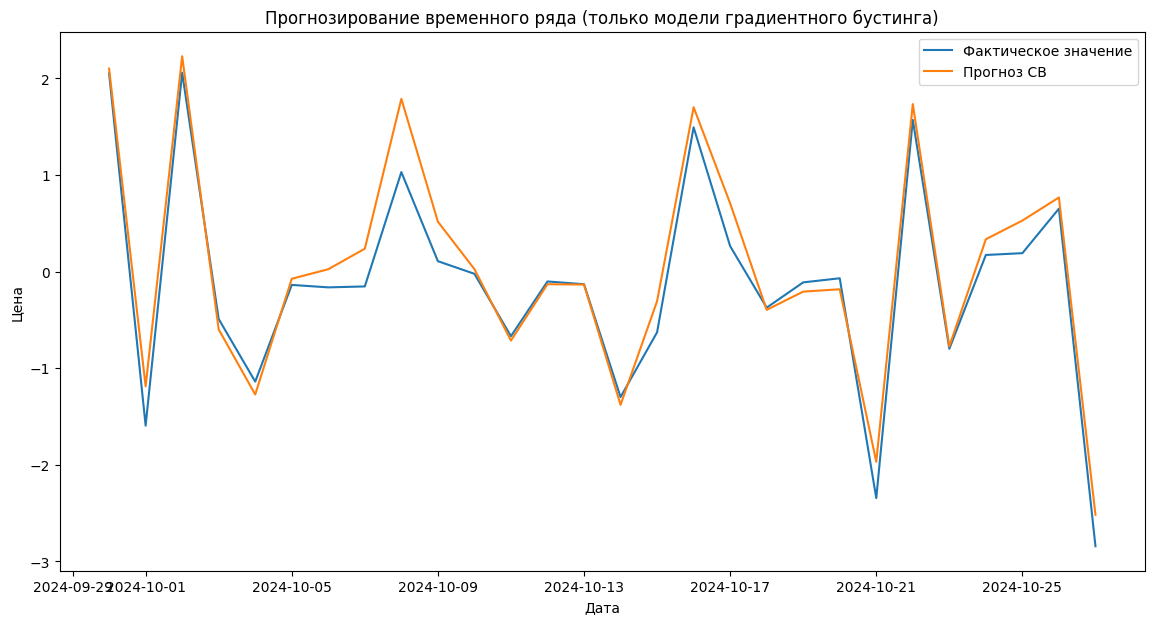

In [18]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, y_test, label='Фактическое значение')
# plt.plot(y_test.index, y_pred_xgb, label='Прогноз GB', linestyle='--')
plt.plot(y_test.index, y_pred_cb, label='Прогноз CB', linestyle='-')
# plt.plot(y_test.index, y_pred_lgbm, label='Прогноз LGBM', linestyle=':')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда (только модели градиентного бустинга)')
plt.legend()
plt.show()

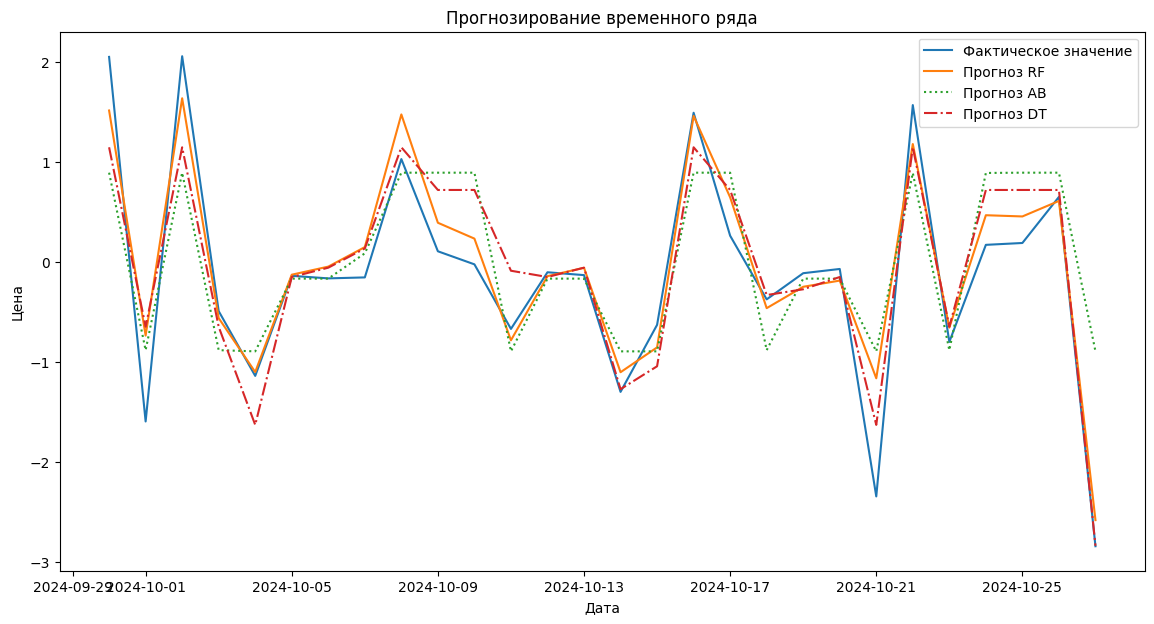

In [19]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, y_test, label='Фактическое значение')
plt.plot(y_test.index, y_pred_rf, label='Прогноз RF', linestyle='-')
plt.plot(y_test.index, y_pred_ab, label='Прогноз AB', linestyle=':')
plt.plot(y_test.index, y_pred_dt, label='Прогноз DT', linestyle='-.')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда')
plt.legend()
plt.show()